# Projekt - Rachunek prawdopodobieństwa i statystyka
## Analiza rekordów Listy Przebojów Trójki z lat 1982-2020
### Autor: Paweł Kruczkiewicz

 **Data analizy: 15.01.2021 oraz 23.01.2021**

W niniejszej pracy pragnę przyjrzeć się jednej z najbardziej znanych i z pewnością najstarszej liście przebojów w Polsce, tj. Liście Przebojów Trójki. Lista tworzona w Programie Trzecim Polskiego Radia, której pomysłodawcą, głównym prowadzącym i twórcą był Marek Niedźwiecki, przez lata kształtowała gusta muzyczne młodych pokoleń polskich słuchaczy.<br>
Niestety w roku 2020, po tzw. ["Aferze w radiowej Trójce"](https://pl.wikipedia.org/wiki/Polskie_Radio_Program_III#Sprawa_pojawienia_si%C4%99_piosenki_%E2%80%9ETw%C3%B3j_b%C3%B3l_jest_lepszy_ni%C5%BC_m%C3%B3j%E2%80%9D_na_Li%C5%9Bcie_Przeboj%C3%B3w), której przyczynkiem było (jak się miało okazać - ostatnie) notowanie nr 1998, Lista Przebojów Radiowej Trójki została "zawieszona".

Jako wyraz uznania dla wieloletniej pracy redaktorów Trójki jak i przejaw zwykłej ciekawości na to, jak wygladały gusta "Trójkowiczów" przez wszystkie te lata, chciałbym krótko przeanalizować niemal 2 tysiące notowań.

## Informacje wstępne
### Krótko o danych
Dane zostały pobrane ze strony https://www.lp3.pl/, skąd zostały "zeskrapowane" z użyciem języka python z pomocą modułu BeautifulSoup4. Pełny kod (wraz z plikiem "requirements.txt") dostępny jest pod tym [linkiem na githubie](https://github.com/pkrucz00/trojkaStats) w pliku `lp3WebScratch`. Zapisuje on dane do pliku CSV, który to został zaimportowany za pomocą aplikacji SQLiteStudio do bazy `listaPrzebojowTrojki.db`

Baza danych składa się z jednej tabeli zawierającej wszystkie rekordy w podanym formacie:

| Nazwa kolumny | Typ Danych | Opis |
| --- | --- | --- |
| Nr notowania | INTEGER | Numer notowania (w przypadku notowań podwójnych, dla uproszczenia numerem notowania jest numer wcześniejszy (np. 665/667 -> 665)) |
| Rok notowania | INTEGER | Rok, w którym odbyło się notowanie |
| Pozycja | INTEGER | Pozycja, jaką osiągnął dany utwór  |
| Tytuł | STRING | Tytuł utworu |
| Artysta | STRING | Wykonawca utworu |
| Punkty | INTEGER | Punkty, które dostaje utwór za swoją pozycję (ze wzoru 30 - nr pozycji + 1) |

Ponieważ liczba utworów w głównym zestawieniu zmieniała się w różnych latach, postanowiłem ujednolicić (oczyścić) dane - do bazy trafiają zawsze te utwory, które zajęły w notowaniu pozycję 30. lub wyższą. Dzięki temu przyporządkowanie punktów jest jednolite (jednak nieco różni się od systemu punktowania stosowanego przez Radiową Trójkę w podsumowaniach rocznych).

W bazie znajduje się 58815 rekordów. Liczba nie jest podzielna przez 30, ponieważ na listę często trafiały miejsca *ex aequo*.

Kontrowersyjne notowanie nr 1998 zostało tutaj zamieszczone zgodnie z tym, jak zostało wyemitowane. Nie wzięto pod uwagę notowania nr 1999.

### Wyłączenie ostrzeżeń i powiadomień (dla czytelności) 

In [1]:
options(warn=-1)
options(dplyr.summarise.inform=F) 

### Podłączenie bazy do języka R

In [6]:
#Zainstaluj paczkę "RSQLite" pozwalającą na użycie bazy danych w postaci obiektu w języku R
#NIE uruchamiaj tej komórki, jeżeli już zainstalowałeś tę paczkę
install.packages("RSQLite")
install.packages("tidyverse")

### Potrzebne biblioteki

In [3]:
library(RSQLite)
library(tidyverse)
library(wesanderson)

### Wypisanie fragmentu bazy danych

In [7]:
con <- dbConnect(RSQLite::SQLite(), dbname="ListaPrzebojowTrojki.db")

dbListTables(con)

#Błąd związany z "mixed type" związany jest z tytułami i artystami,
#którzy zawierają w swojej nazwie liczby (np. '51' zespołu TSA)
records <- dbReadTable(con, "Records")
records[1:15, ]

dbDisconnect(con)

[1] "Records"

Nr.notowania,Rok.notowania,Pozycja,Tytuł,Artysta,Punkty
1,1982,1,I'll Find My Way Home,Jon & Vangelis,30
1,1982,2,O! Nie rób tyle hałasu,Maanam,29
1,1982,3,For Those About to Rock (We Salute You),AC/DC,28
1,1982,4,51,TSA,27
1,1982,5,Opanuj się,Perfect,26
1,1982,6,The Visitors (Crackin' Up),ABBA,25
1,1982,7,Flying Colours,Jethro Tull,24
1,1982,8,Pepe wróć,Perfect,23
1,1982,9,Teraz rób co chcesz,Budka Suflera,22
1,1982,10,Słodka jest noc,Kombi,21


## Analiza wstępna/eksploracyjna
### Poprawność danych
Na sam początek możemy sprawdzić, czy zebrane dane są poprawne. Sprawdźmy liczbę, medianę i średnią wszystkich rekordów

In [6]:
records %>% 
summarise(
    liczba.rekordów = n(),
    mediana = median(Punkty),
    średnia = mean(Punkty))

liczba.rekordów,mediana,średnia
58815,15,15.49499


Jak widać, mediana zbioru to 15, średnia jest bardzo bliska wartości oczekiwanej. Delikatna różnica spowodowana jest wspomnianymi wcześniej miejscami ex aequo.

### Analiza pojedynczych utworów
A jak analogiczne statystyki wyglądają dla poszczególnych piosenek?

In [7]:
records %>%
    transmute(
        Piosenka = paste(Tytuł, Artysta, sep=" - "),
        Punkty=Punkty
    ) %>%
    group_by(Piosenka)%>%
    summarize(
        sumaPunktów = sum(Punkty),
        liczbaWystapien = n()
    )%>%
    summarize(
        śr.tyg.na.liscie = mean(liczbaWystapien),
        med.tyg.na.liscie = median(liczbaWystapien),
        śr.suma.punktów = mean(sumaPunktów),
        med.sumy.punktow = median(sumaPunktów)
    )

śr.tyg.na.liscie,med.tyg.na.liscie,śr.suma.punktów,med.sumy.punktow
9.448193,8,146.3997,86


Nawet tak prosty test jak wyżej przyniósł ciekawe wyniki! Średnia jest oddalona od mediany, co w statystyce oznacza, że zbiór jest skrzywiony w stronę mniejszych wartości.Narysujmy zatem oba histogramy - wykresy liczby utworów w zależności od liczby tygodni w zestawieniu oraz sumy zdobytych punktów

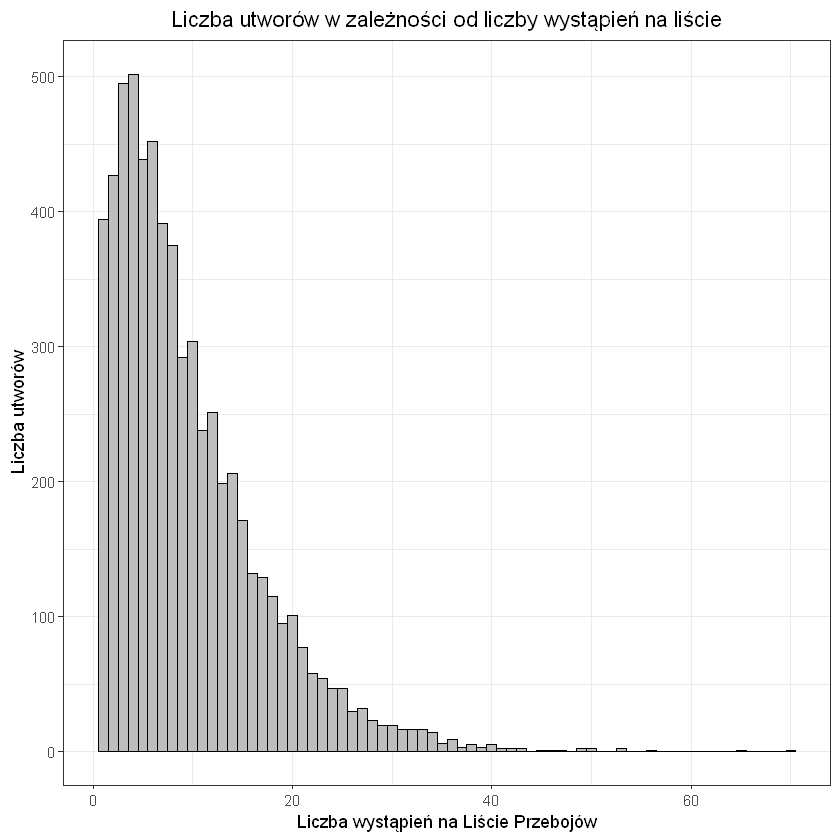

In [8]:
records %>%
    transmute(
        Piosenka = paste(Tytuł, Artysta, sep=" - "),
        Punkty=Punkty
    ) %>%
    group_by(Piosenka)%>%
    summarize(
        liczbaWystapien = n(),
        )%>%
    ggplot() + theme_bw()+
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_bar(aes(x=liczbaWystapien), stat="bin", binwidth=1, fill="grey", colour="black") +
    ylab("Liczba utworów") +
    xlab("Liczba wystąpień na Liście Przebojów") +
    ggtitle("Liczba utworów w zależności od liczby wystąpień na liście")


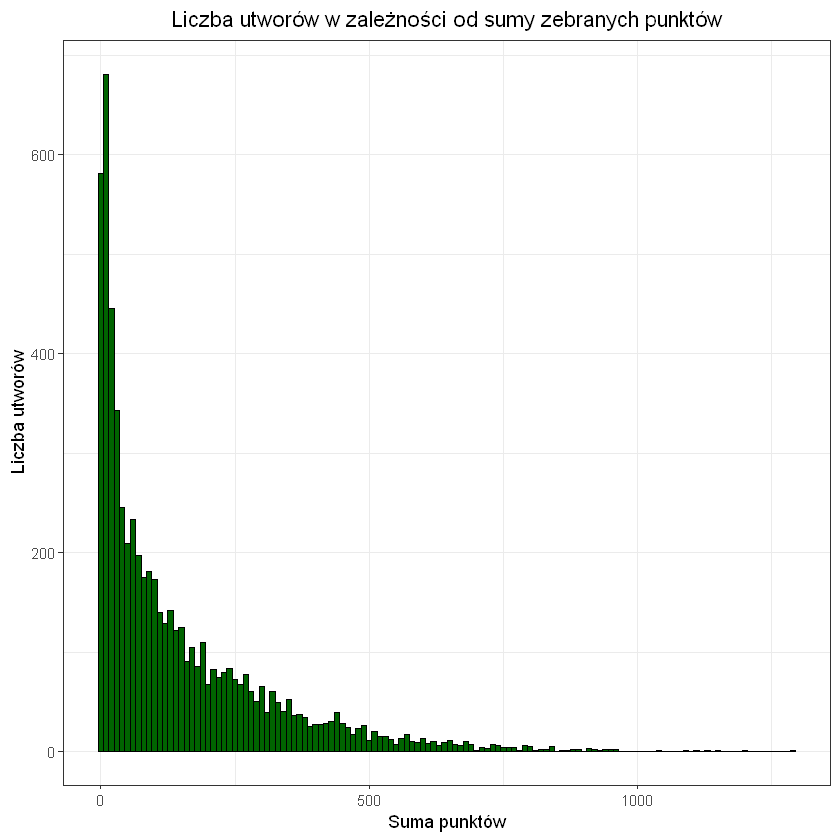

In [29]:
records %>%
    transmute(
        Piosenka = paste(Tytuł, Artysta, sep=" - "),
        Punkty=Punkty
    ) %>%
    group_by(Piosenka)%>%
    summarize(
        sumaPunktów = sum(Punkty),
        )%>%
    ggplot() +
    theme_bw()+
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_bar(aes(x=sumaPunktów), stat="bin", binwidth=10, fill='darkgreen', colour='black') + ylab("Liczba utworów") +
    ggtitle("Liczba utworów w zależności od sumy zebranych punktów") +
    xlab("Suma punktów")

Teraz od razu widać prostą zależność - zdecydowana większość utworów znajduje się w zestawieniu zajmuje niskie pozycje, uzyskując w ten sposób niską sumaryczną punktację. Niewielka liczba utworów przełamuje barierę 500 punktów, jeszcze mniej 1000. Sprawdźmy zatem, jak wygląda ów "top" utworów.

### TOP utworów i artystów Listy Przebojów Trójki

Poniżej zestawiono 20 utworów o największej sumarycznej liczbie punktów

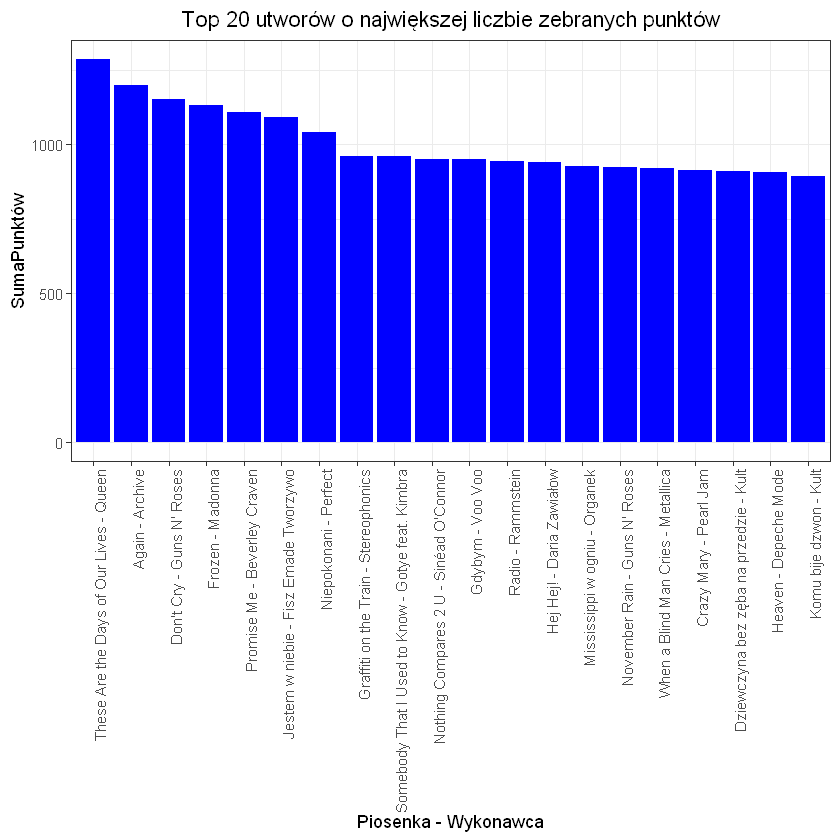

In [12]:
records %>%
    transmute(
        Piosenka = paste(Tytuł, Artysta, sep=" - "),
        Punkty=Punkty
    )%>%
    group_by(Piosenka) %>%
    summarise(
          SumaPunktów = sum(Punkty)
          ) %>%
    top_n(20, SumaPunktów) %>%
    
    ggplot() +
    geom_bar(aes(x = reorder(Piosenka, -SumaPunktów), y = SumaPunktów), stat="identity", fill='blue')+
    theme_bw()+
    theme(axis.text.x = element_text(angle=90, hjust=1), plot.title = element_text(hjust = 0.5)) +
    xlab("Piosenka - Wykonawca")+
    ggtitle("Top 20 utworów o największej liczbie zebranych punktów")

Sprawdźmy również, ile dokładnie utworów przekroczyło bariery okrągłej liczby punktów

In [13]:
tableWithPoints <-    
    records %>% 
    transmute(
        Piosenka = paste(Tytuł, Artysta, sep=" - "),
        Punkty=Punkty
    )%>%
    group_by(Piosenka) %>%
    summarise(SumaPunktów = sum(Punkty))

numberOfSongs <-
    records %>%
    transmute(Piosenka = paste(Tytuł, Artysta, sep=" - "))%>%
    distinct() %>%
    summarise(liczbaPiosenek = n())


progi = seq(0, 1000, by=100)
liczbaPiosenekPowyzejProgu = c()
procent = c()
res <- data.frame()
for (Próg in progi){
    
    tmp <-
        tableWithPoints %>%
        filter(SumaPunktów > Próg) %>%
        summarize(Liczba.Piosenek = n())
    pr <- round(tmp*100/numberOfSongs, 2)
    newRow <- cbind(Próg, tmp, pr)
    res <- rbind(res, newRow)
}
names(res)[3] <- "Procent"
res

Próg,Liczba.Piosenek,Procent
0,6225,100.00
100,2844,45.69
200,1677,26.94
300,972,15.61
400,548,8.80
500,291,4.67
600,159,2.55
700,79,1.27
800,38,0.61
900,19,0.31


Podobny jak wyżej histogram można również stworzyć dla liczby punktów zdobytych przez danego artystę

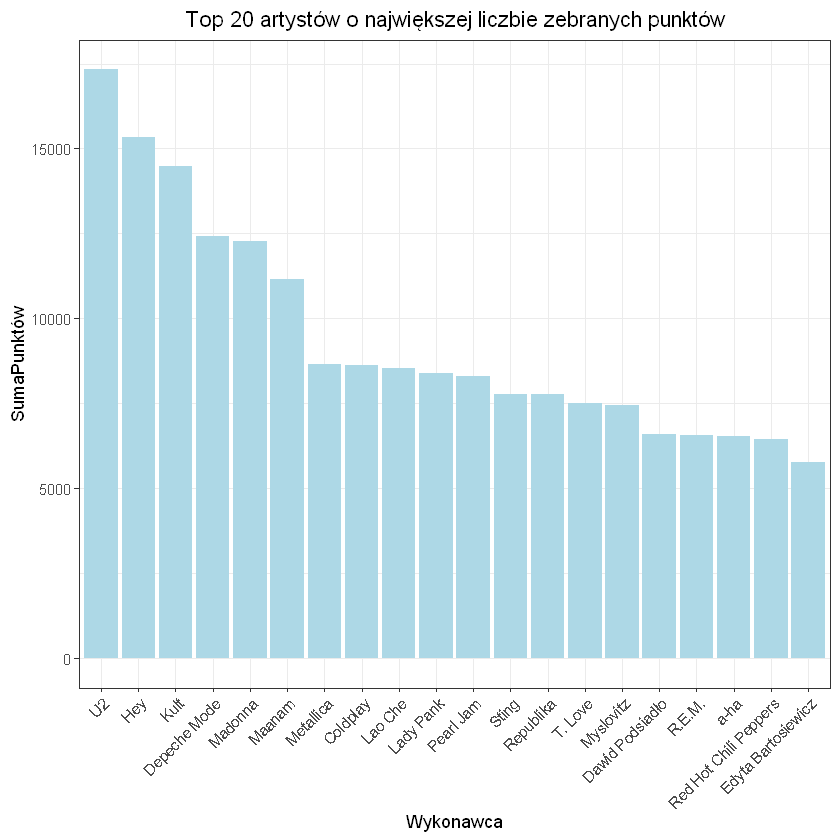

In [14]:
records %>%
    select(Artysta, Punkty) %>%
    group_by(Artysta) %>%
    summarise(
        SumaPunktów = sum(Punkty)
        )%>%
    top_n(20, SumaPunktów) %>%
    
    ggplot() +
    geom_bar(aes(x = reorder(Artysta, -SumaPunktów), y = SumaPunktów), stat="identity", fill='lightblue')+
    theme_bw()+
    theme(axis.text.x = element_text(angle=45, hjust=1), plot.title = element_text(hjust = 0.5)) +
    xlab("Wykonawca")+
    ggtitle("Top 20 artystów o największej liczbie zebranych punktów")
    

Jak suma punktów rozkładała się dla podanych wyżej twórców w ciągu kolejnych notowań?

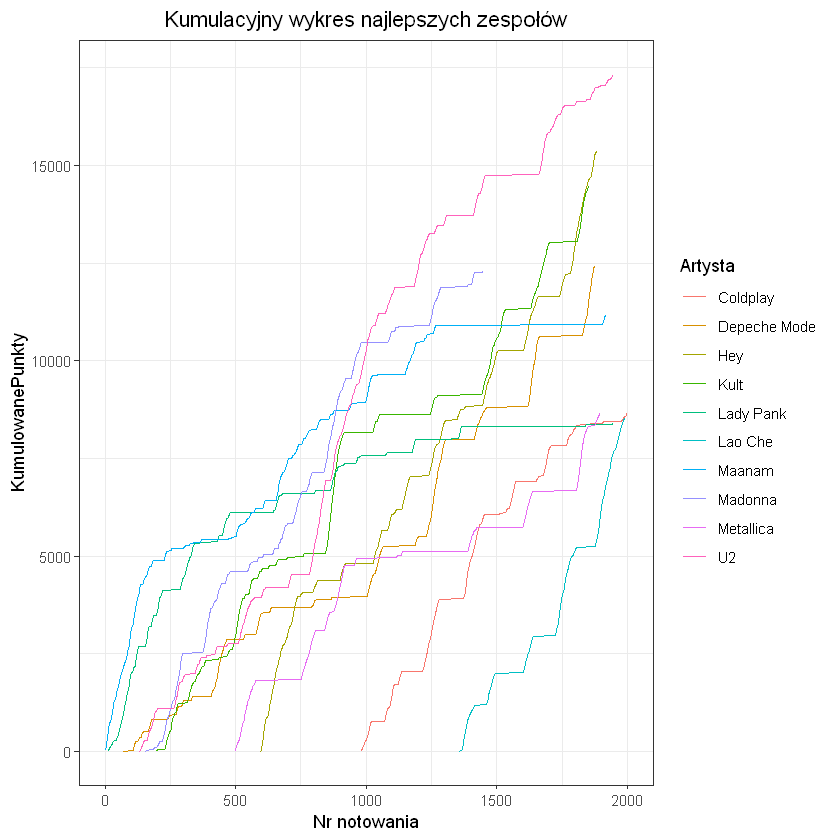

In [17]:
topArtystow <-
    records %>%
    select(Artysta, Punkty) %>%
    group_by(Artysta) %>%
    summarise(
        SumaPunktów = sum(Punkty)
        )%>%
    top_n(10, SumaPunktów)

najlepsiArtysci <- topArtystow$Artysta

records %>%
filter(Artysta %in% najlepsiArtysci) %>%
group_by(Artysta) %>%
mutate(KumulowanePunkty=cumsum(Punkty)) %>%
select(Nr.notowania, Artysta, KumulowanePunkty) %>%
ggplot() +
theme_bw() +
theme(plot.title = element_text(hjust = 0.5)) +
geom_line(aes(Nr.notowania, KumulowanePunkty, color=Artysta)) +
ggtitle("Kumulacyjny wykres najlepszych zespołów") +
xlab("Nr notowania")

Powyższy wykres pokazuje nam o wiele dokładniejsze dane niż sam histogram. Teraz widać wyraźnie, że artyści tacy jak Maanam czy Lady Pank "zapewnili" sobie najwyższe miejsca już w pierwszych notowaniach, natomiast nowsze zespoły, takie jak np. Lao Che wspinały się dynamicznie w ciągu ostatnich kilkuset notowań.

### Najlepsze utwory poszczególnych wykonawców
Również "skoki" wskazują na dużą liczbę punktów zdobywanych w krótkim czasie, tzw. "hitów". Jakie piosenki przyniosły najwięcej punktów dla poszczgólnych artystów?

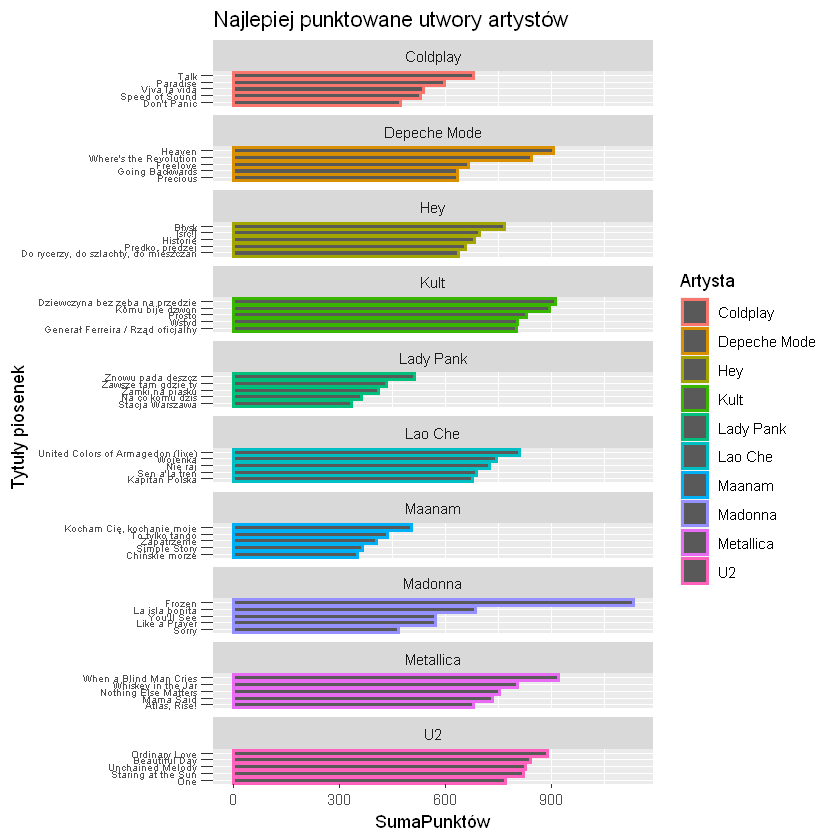

In [30]:
topArtystow <-
    records %>%
    select(Artysta, Punkty) %>%
    group_by(Artysta) %>%
    summarise(
        SumaPunktów = sum(Punkty)
        )%>%
    top_n(10, SumaPunktów)

najlepsiArtysci <- topArtystow$Artysta

records %>%
filter(Artysta %in% najlepsiArtysci) %>%
group_by(Artysta, Tytuł) %>%
summarise(
    SumaPunktów = sum(Punkty)
    ) %>%
ungroup() %>%
group_by(Artysta) %>%
arrange(desc(SumaPunktów)) %>%
top_n(5, SumaPunktów) %>%
ggplot() +
geom_bar(aes(x = reorder(Tytuł, SumaPunktów), SumaPunktów, color=Artysta), stat="identity", size=0.9)+
theme(axis.ticks.length.y=unit(0.25, "cm"), axis.text.y = element_text(size=6, hjust=1))+
facet_wrap(~Artysta, scales="free_y", ncol=1)+ coord_flip() +
xlab("Tytuły piosenek") +
ggtitle("Najlepiej punktowane utwory artystów")

## Badanie hipotez
### *Mnie się podobają melodie, które już raz słyszałem*, czyli czy znane nazwiska artystów zapewniają wyższe pozycje?
#### Główna myśl
Aby znaleźć (przybliżoną) odpowiedź na powyższe pytanie, można sprawdzić, czy istnieje korelacja między liczbą piosenek w zestawieniu danego artysty, a liczbą punktów na dany utwór 

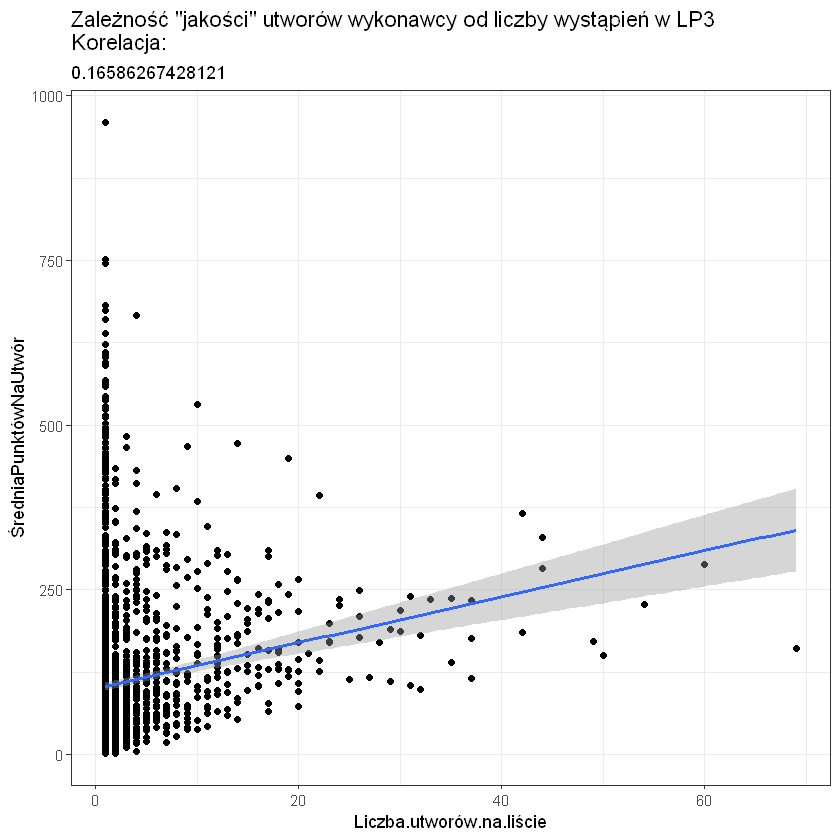

In [19]:
#Artyści wg liczby piosenek w liście
liczbaPiosenekNaArtyste <- 
    records %>%
    select(Tytuł, Artysta) %>%
    distinct() %>%
    group_by(Artysta) %>%
    summarise(Liczba.utworów.na.liście = n()) %>%
    arrange(desc(Liczba.utworów.na.liście)) %>%
    ungroup()

#Średnia punktów na utwór
śrPktNaArtyste <- records %>%
    select(Artysta, Tytuł, Punkty) %>%
    group_by(Artysta, Tytuł) %>%
    summarise(
        SumaPunktów = sum(Punkty),   #sumaryczna liczba punktów dla każdego utworu
        ) %>%
    ungroup() %>%
    group_by(Artysta) %>%
    summarise(
        ŚredniaPunktówNaUtwór = mean(SumaPunktów)
    ) %>% arrange(desc(ŚredniaPunktówNaUtwór))%>%
    ungroup()

joinedTable <- left_join(liczbaPiosenekNaArtyste, śrPktNaArtyste, by="Artysta")
korelacja <- cor(joinedTable$Liczba.utworów.na.liście, joinedTable$ŚredniaPunktówNaUtwór)

joinedTable %>%
    #top_n(20, Liczba.utworów.na.liście) %>%
    ggplot(aes(x = Liczba.utworów.na.liście, y=ŚredniaPunktówNaUtwór)) +
    geom_point() +
    stat_smooth(method = lm, formula=y~x) +  #poszukiwanie regresji liniowej
    theme_bw() +
    ggtitle("Zależność \"jakości\" utworów wykonawcy od liczby wystąpień w LP3\nKorelacja:" , korelacja)

Jak widać na powyższym wykresie, korelacja jest znikoma. Linia regresji prawie w ogóle nie wskazuje punktów znajdujących się na rysunku.

Osobiście uważam, że niski współczynnik korelacji to dobry znak - znani artyści nie determinują wyglądu listy w stopniu znacznym, dzięki czemu utalentowani młodzi artyści również mogą znaleźć się na liście.

#### Spostrzeżenie
Jednak przyglądając się szczytom powyższych tabel, zauważyłem pewien szczegół:

In [20]:
śrPktNaArtyste %>% top_n(20, ŚredniaPunktówNaUtwór)

Artysta,ŚredniaPunktówNaUtwór
Gotye feat. Kimbra,960.00
Fisz Emade Tworzywo feat. Justyna Święs,752.00
Zbigniew Zamachowski i Grupa MoCarta,746.00
"Fisz, Emade, Tworzywo feat. Kasia Nosowska",682.00
Michael Jackson feat. special guitar performance by Slash,674.00
Organek,666.75
Męskie Granie Orkiestra 2018,660.00
Kazik & Edyta Bartosiewicz,639.00
Basia Stępniak-Wilk & Grzegorz Turnau,623.00
Mira Kubasińska & After Blues,610.00


Zaobserwowałem, że początek powyższej tabeli jest stosunkowo pełen muzycznych kolaboracji, np. "Kazik & Edyta Bartosiewicz", "Gotye feat. Kimbra". Czy jest to ogólna zasada? Czy pojedyncze współprace między artystami to klucz do sukcesu? Sprawdźmy zatem, jak wygląda to dla całej tabeli.

#### Test
Dla uproszczenia przyjmiemy, że muzyczne kolaboracje mają w nazwie znak "&" bądź słowo "feat." czyli "featuring". Ważne jest, że nie jest to metoda perfekcyjna. Często nie jest to jednorazowa współpraca jak w przypadku Nicka Cave'a i zespołu The Bad Seeds, którzy tworzą muzykę wspólnie już przez kilka dekad. Nie wliczamy jednak np. Męskiego Grania 2018, które jest oczywiście, zbiorem twórców tworzących zazwyczaj osobno

nazwa,liczba_utworów,średnia_liczba_punktów,mediana,odchylenie_standardowe
Wszyscy artyści,1826,111.6308,73.30952,122.6950
Kolaboracje,371,137.1124,68.00000,164.3714


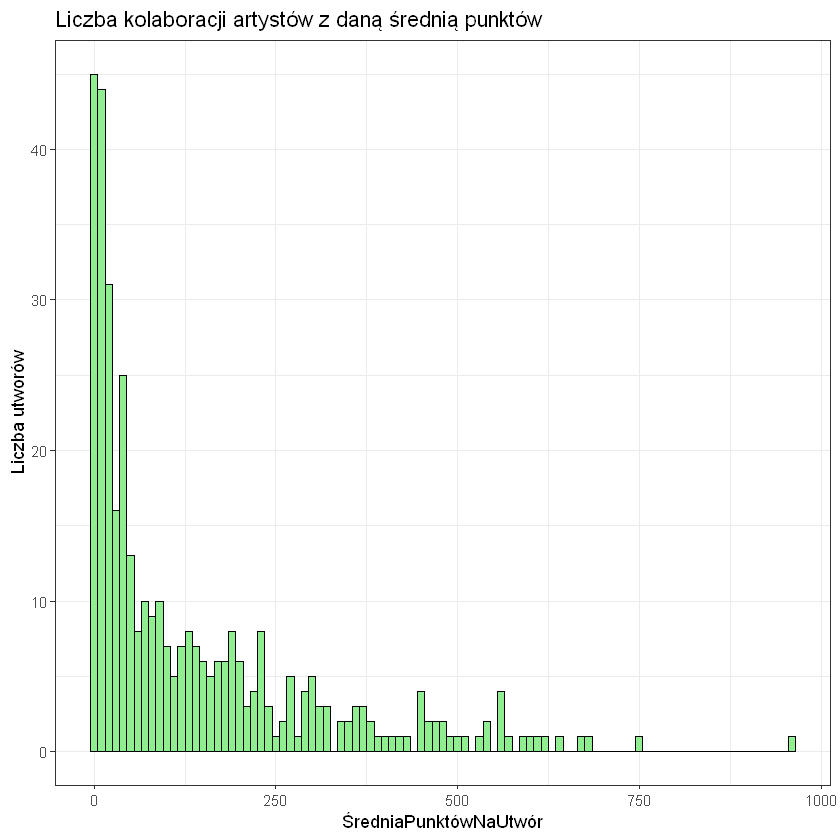

In [25]:
kolaboracjeTabela <-
    śrPktNaArtyste %>%
    filter(str_detect(Artysta, '&|feat.'))

calosciowo <-
    śrPktNaArtyste %>%
    summarise(
        nazwa = "Wszyscy artyści",
        liczba_utworów= n(),
        średnia_liczba_punktów = mean(ŚredniaPunktówNaUtwór),
        mediana = median(ŚredniaPunktówNaUtwór),
        odchylenie_standardowe = sd(ŚredniaPunktówNaUtwór)
        )

kolaboracje <-     
    kolaboracjeTabela %>%
    summarise(
        nazwa = "Kolaboracje",
        liczba_utworów = n(),
        średnia_liczba_punktów = mean(ŚredniaPunktówNaUtwór),
        mediana = median(ŚredniaPunktówNaUtwór),
        odchylenie_standardowe = sd(ŚredniaPunktówNaUtwór)
        )


rbind(calosciowo, kolaboracje)

śrPktNaArtyste %>%    
filter(str_detect(Artysta, '&|feat.')) %>%
ggplot(aes(ŚredniaPunktówNaUtwór)) +
    theme_bw()+
    geom_bar( stat="bin", binwidth=10, fill='lightgreen', colour='black') + ylab("Liczba utworów")+
    ggtitle("Liczba kolaboracji artystów z daną średnią punktów")

Powyższa tabelka pokazuje, że początkowa hipoteza na bazie fragmentu danych, nie była poprawna. Utwory powstałe jako muzyczne kolaboracje mają co prawda wyższą średnią sumarycznych punktów na utwór, jednak niższą medianę. Oznacza to, że w porównaniu z ogółem utworów, omawiane piosenki mogą w znaczący sposób "wyprzedzić" resztę, jednak jest to jeszcze bardziej niepewne niż w normalnym przypadku, na co wskazuje również większe odchylenie standardowe.

Sprawdźmy, czy istnieje korelacja między liczbą piosenek w zestawieniu a średnią zdobytą liczbą punktów na utwór dla utworów muzycznych kolaboracji

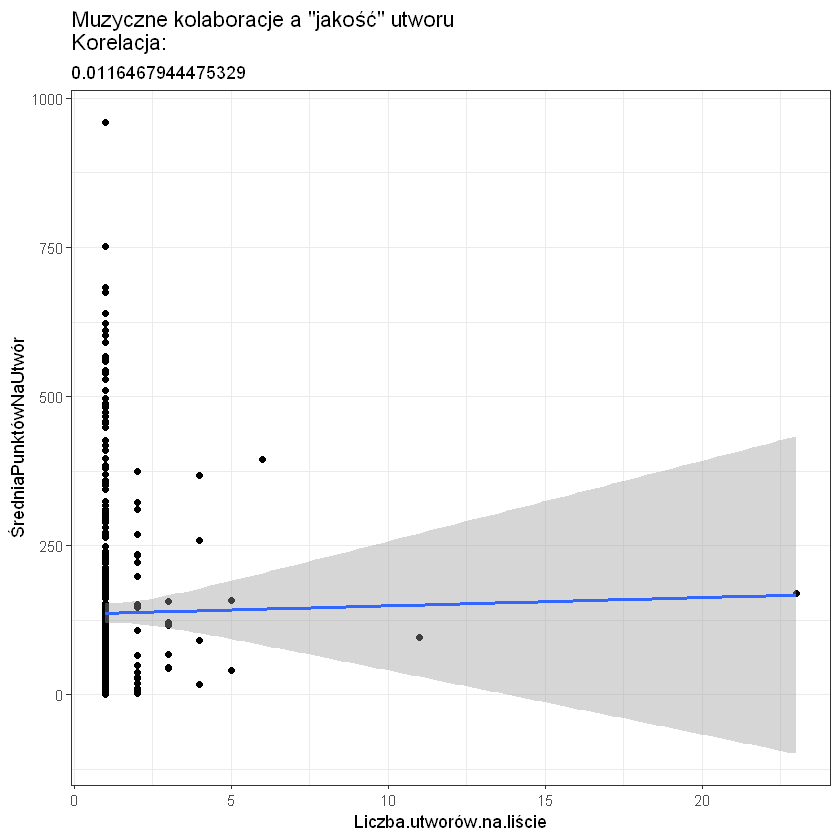

In [23]:
kolaboracjeLiczbaPiosenek <- (liczbaPiosenekNaArtyste %>% filter(str_detect(Artysta, '&|feat.')))
kolaboracjeŚrednia <- (śrPktNaArtyste %>% filter(str_detect(Artysta, '&|feat.')))                      

joinedTable <- left_join(kolaboracjeLiczbaPiosenek, kolaboracjeŚrednia, by="Artysta")
korelacja <- cor(joinedTable$Liczba.utworów.na.liście, joinedTable$ŚredniaPunktówNaUtwór)

    joinedTable %>%
    ggplot(aes(x = Liczba.utworów.na.liście, y=ŚredniaPunktówNaUtwór)) +
    geom_point() +
    stat_smooth(method = lm, formula=y~x) +  #poszukiwanie regresji liniowej
    theme_bw() +
    ggtitle("Muzyczne kolaboracje a \"jakość\" utworu\nKorelacja:", korelacja)

Jak widać - teraz korelacja jest jeszcze mniejsza. Oczywiście można również sprawdzić, czy kolaboracje częstych "bywaczy" na liście (jak np. "Kazik & Edyta Bartosiewicz") zapewniają więcej punktów niż typowy efekt współpracy między twórcami, jednak jest to już historia na inny czas

### Czy wysoki debiut zapewnia długi czas na liście?
#### Główna myśl
Możemy również zadać sobie pytanie - czy utwory, które zaczynają "z najwyższej belki", stają się przebojami na długo? Czy istnieje i jeżeli tak, to jak wygląda zależność między wysokim debiutem a liczbą tygodni spędzonych na Liście Przebojów Trójki


	Pearson's product-moment correlation

data:  res$PozycjaDebiutu and res$TygNaLiście
t = -29.925, df = 6223, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3762059 -0.3327679
sample estimates:
       cor 
-0.3546783 


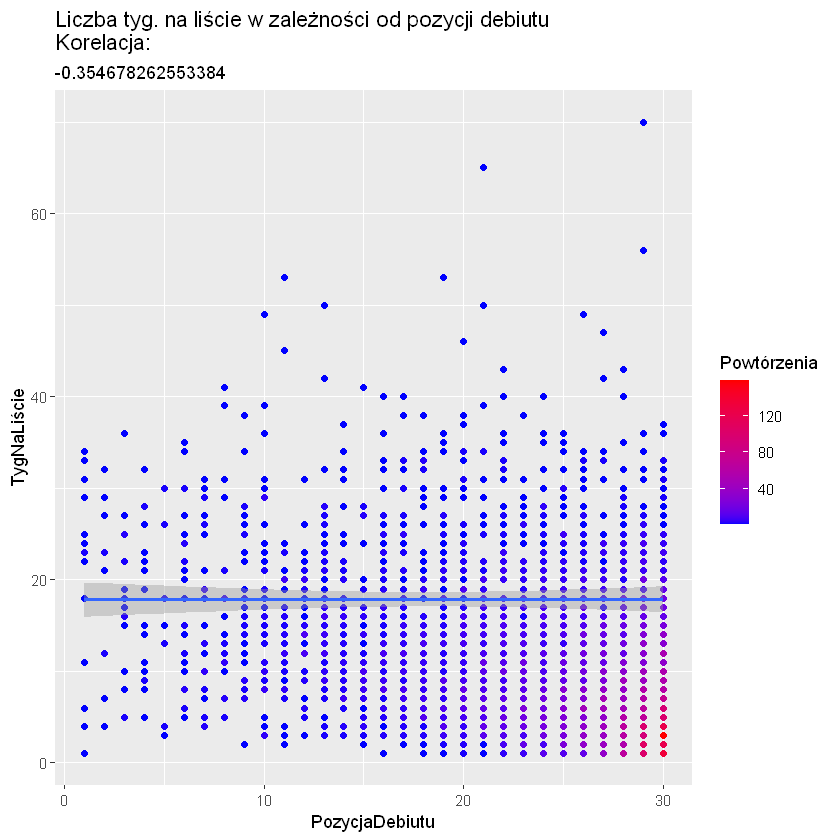

In [24]:
res <- 
    records %>%
    group_by(Tytuł, Artysta) %>%
    arrange(Tytuł, Artysta) %>%
    mutate(TygNaLiście=n()) %>%
    filter(row_number()==1) %>%
    select(Tytuł, Artysta, Pozycja, TygNaLiście) %>%
    rename(PozycjaDebiutu = Pozycja) %>%
    ungroup()

cor <- cor(res$PozycjaDebiutu, res$TygNaLiście)
cor.test(res$PozycjaDebiutu, res$TygNaLiście)

pktDoNarysowania <- 
    res %>%
    group_by(PozycjaDebiutu, TygNaLiście) %>%
    summarise(Powtórzenia = n())

pktDoNarysowania %>%
    ggplot(aes(x = PozycjaDebiutu, y=TygNaLiście, color=Powtórzenia)) +
    geom_point() +
    scale_color_gradient(low="blue", high="red") +
    geom_smooth(method=lm, formula=y~x) +
    ggtitle("Liczba tyg. na liście w zależności od pozycji debiutu\nKorelacja:" , cor)
    

Na bazie wyliczonej korelacji oraz testu Pearsona można stwierdzić, że istnieje pewna ujemna korelacja między wysokim debiutem a długim występowaniem utworu na liście przebojów.

#### Wyjątki od reguły
Należy jednak zauważyć, że jest to stosunkowo mała korelacja, od której zdarzają się znaczne wyjątki. Tak np. wyglądała droga na szczyt utworu *Again* zespołu *Archive* 

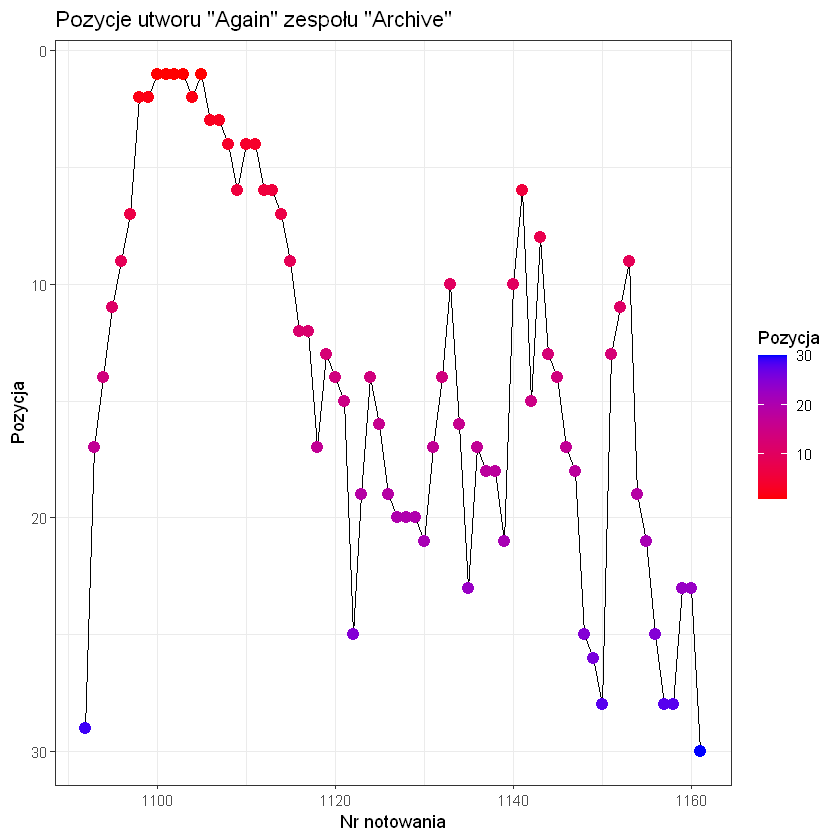

In [31]:
records %>%
    filter(Tytuł=="Again", Artysta=="Archive") %>%
    ggplot() +
    geom_line(aes(Nr.notowania, Pozycja)) + theme_bw() + scale_y_reverse() +
    geom_point(aes(Nr.notowania, Pozycja,color=Pozycja), size=3) +
    scale_color_gradient(low="red", high="blue") +
    ggtitle("Pozycje utworu \"Again\" zespołu \"Archive\"") + xlab("Nr notowania")

Jak widać - wysoka belka nie zawsze oznacza wysoki skok.

### *Efekt Męskiego Grania*,  czyli o wpływie muzycznej inicjatywy Żywca na Listę Przebojów
#### Wstęp
Na koniec sprawdzimy, czy i jakich artystów "wypromowała" trasa "Męskiego Grania".
"Męskie granie" to zainicjowana i tworzona przez markę Żywiec trasa koncertowa, skupiająca sporą grupę polskich artystów związanych ze sceną rockową i hiphopową. Pierwsze koncerty rozpoczęły się w 2010; promujący tę trasę singiel *Wszyscy muzycy to wojownicy* przez 24 tygodnie znajdował się na Liście Przebojów Trójki, uzyskując 482 punkty (co pokazuje poniższa tabela).

Przez następne lata skala projektu rosła, a wraz z nią pozycje "Męskiego grania" na Liście, co widać na poniższym diagramie, przedstawiającym sumy punktów uzyskanych przez utwory wydane pod szyldem "Męskiego Grania" w kolejnych latach.

Tytuł,Tyg_na_liście,Suma_Punktów
Wszyscy muzycy to wojownicy,24,482


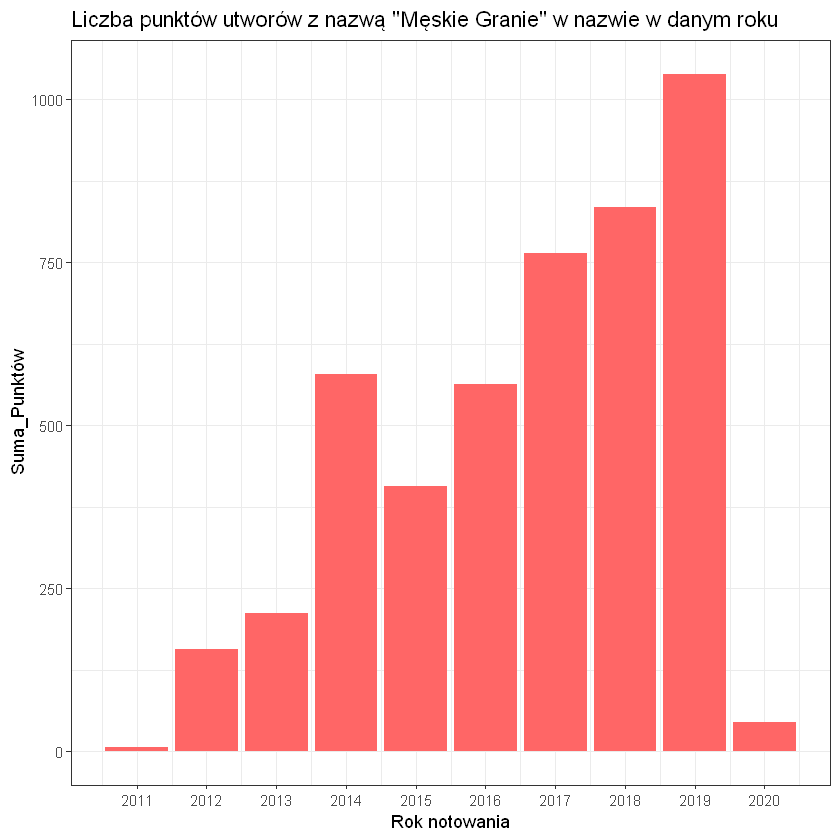

In [32]:
records %>%
    filter(str_detect(Tytuł, "Wszyscy muzycy to wojownicy")) %>%
    group_by(Tytuł) %>%
    summarise(Tyg_na_liście = n(),
              Suma_Punktów = sum(Punkty))

records %>% 
    filter(str_detect(Artysta, 'Męskie Granie')) %>%
    group_by(Rok.notowania) %>%
    summarise(Suma_Punktów = sum(Punkty)) %>%
    ggplot(aes(Rok.notowania, Suma_Punktów)) +
    theme_bw() +
    geom_bar(stat="identity", fill='#FF6666') + scale_x_continuous(breaks = seq(2010, 2020, by = 1)) +
    ggtitle("Liczba punktów utworów z nazwą \"Męskie Granie\" w nazwie w danym roku") + xlab("Rok notowania")
    


O ile sam wzrost popularności Męskiego Grania nie ulega wątpliwości, tak możemy sprawdzić, jaki wpływ miał on na pozycje niektórych artystów w nim występujących. W tym celu sprawdzimy kumulowane punkty na przestrzeni lat danych artystów biorących udział w projekcie.

#### Sposób wykonania testu
Do punktów danego artysty doliczamy wszystkie jego kolaboracje z innyi artystami oprócz Męskiego Grania (czyli jeśli ich nazwisko pojawiło się w rubryce "Artysta").
Widoczne na wykresie wertykalne linie to daty pierwszych koncertów danej edycji Męskiego Grania dla odpowiednio 2010, 2014, 2017 i 2019 roku. Wybrano je, ponieważ wtedy popularność utworów Męskiego Grania (wg powyższego wykresu) była największa.
 
 
Sami "artyści męskiego grania" zostali wybrani arbitralnie. Niestety nie znalazłem bazy danych, która zawierałaby wszystkich artystów zaangażowanych w tenże projekt. Starałem się zatem wymienić czołowe nazwiska, które towarzyszyły niejednokrotnie zarówno Męskiemu Graniu, jak i omawianej liście.

#### Test



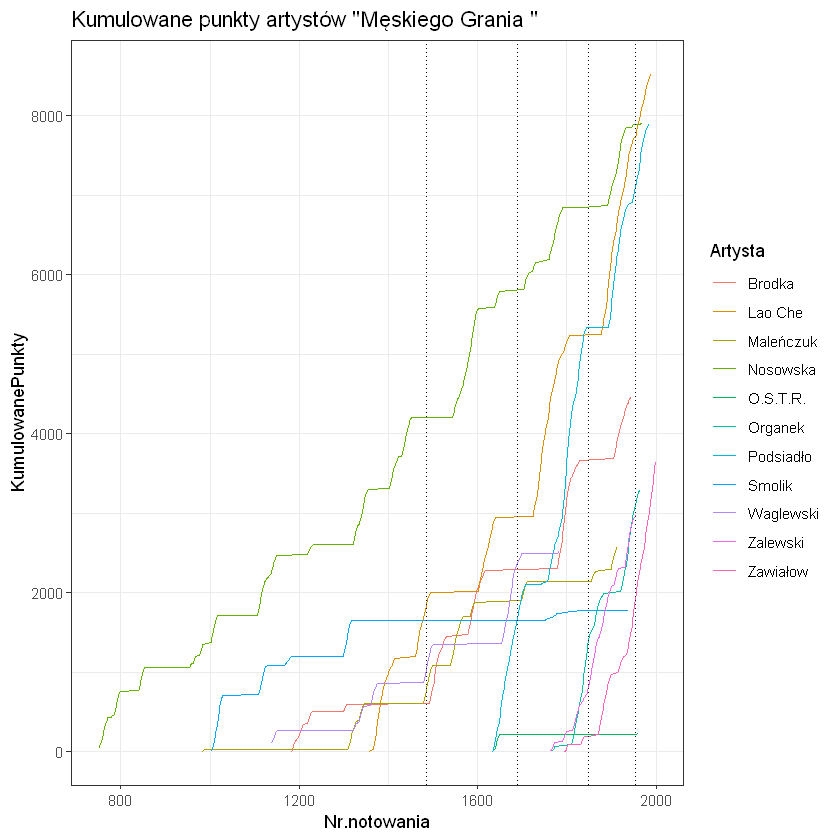

In [200]:
artysci_meskiego_grania <- c("O.S.T.R.", "Lao Che", "Brodka", "Zawiałow", "Nosowska", "Waglewski", "Organek", "Podsiadło", "Zalewski", "Maleńczuk", "Smolik")

res <- data.frame(Nr.notowania=integer(),
                  Rok.notowania=integer(),
                  Artysta=character(),
                  KumulowanePunkty=integer())

for (artystaMesGran in artysci_meskiego_grania){
    tmp <-
        records %>%
        filter(str_detect(Artysta, artystaMesGran))%>%
        mutate(KumulowanePunkty=cumsum(Punkty)) %>%
        mutate(Artysta=artystaMesGran) %>%
        select(Nr.notowania, Rok.notowania, Artysta, KumulowanePunkty)
    
    res <- rbind(res, tmp)
}

res <- res %>% 
    filter(Nr.notowania > 750)  #zbyt "stare" notowania

nr_notowania_m_gran = c(1486,   #1. koncert Męskiego Grania
                        1690,   #1. koncert MG 2014
                        1849,   #1. koncert MG 2017
                        1954)   #1. koncert MG 2019
res %>% 
    ggplot() + ggtitle("Kumulowane punkty artystów \"Męskiego Grania \"") +
    geom_line(aes(Nr.notowania, KumulowanePunkty, color=Artysta)) + theme_bw() + geom_vline(xintercept=nr_notowania_m_gran, linetype="dotted")

#### Prosta analiza
Pomimo dosyć małej liczby analizowanych twórców, można ich podzielić na pomniejsze grupy artystów:
1. na których pozycje w liście przebojów znacznie nie wpłynęła
2. którzy tworzyli wcześniej, lecz dzięki Męskiemu Graniu lepiej radzili sobie na liście
3. którzy zdobyli sporą popularność po powstaniu Męskiego Grania

Analizę pierwszej grupy pominiemy, do których z wybranej próbki możemy zaliczyć jedynie Andrzeja Smolika, który jako jedyny radził sobie lepiej na liście przed rozpoczęciem Męskiego Grania, oraz rapera O.S.T.R., który pomimo znacznego zaangażowania w Męskie Granie, na listę przebojów dostał się jedynie z utworami współtworzonymi z Organkiem i Katarzyną Nosowską. Należy pamiętać, że takich artystów z pewnością jest więcej.

Druga grupa jest o wiele bardziej interesująca. Możemy do niej zaliczyć m.in. Brodkę, Katarzynę Nosowską, Lao Che czy Macieja Maleńczuka

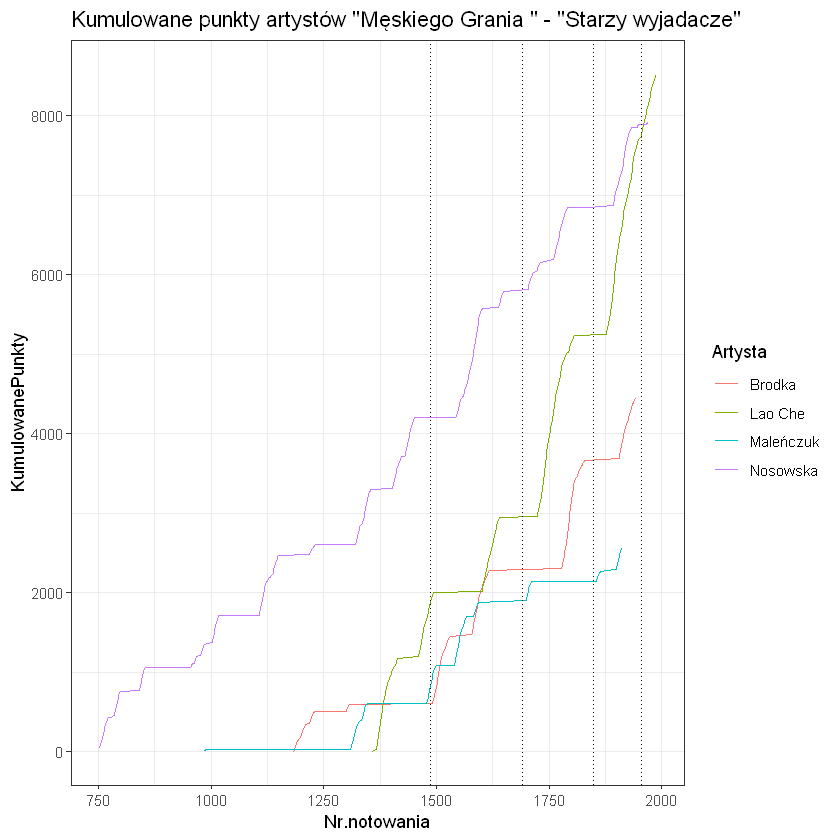

In [204]:
druga_grupa <- c("Nosowska", "Brodka", "Maleńczuk", "Lao Che")

res %>% filter(Artysta %in% druga_grupa) %>%
ggplot() + ggtitle("Kumulowane punkty artystów \"Męskiego Grania \" - \"Starzy wyjadacze\"") +
    geom_line(aes(Nr.notowania, KumulowanePunkty, color=Artysta)) + theme_bw() + geom_vline(xintercept=nr_notowania_m_gran, linetype="dotted")
    

O ile Katarzyna Nosowska (wokalistka grupy *Hey*) radziła sobie bardzo dobrze jeszcze przed współpracą z Męskim Graniem, tak Brodka i Maleńczuk lepiej zaznaczyli swoje miejsce na liście po rozpoczęciu omawianego festiwalu. Oczywiście nadinterpretacją byłoby stwierdzić, że omawiani artyści zawdzięczają swoje wysokie pozycje jedynie festiwalowi Żywca, ale z pewnością istnieje korelacja między ich popularnością na liście a uczestnictwem w MG.

Trzecia grupa to artyści, którzy pojawili się na liście po rozpoczęciu Męskiego Grania. Są to m.in. Organek, Dawid Podsiadło, Daria Zawiałow czy Krzysztow Zalewski

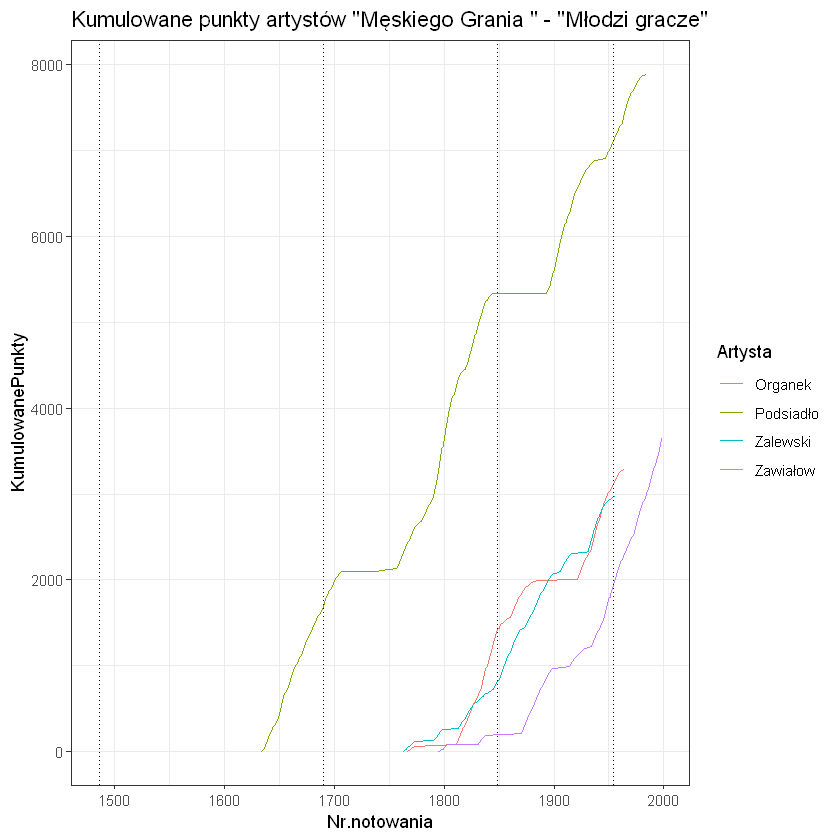

In [206]:
trzecia_grupa <- c("Zawiałow", "Organek", "Podsiadło", "Zalewski")

res %>% filter(Artysta %in% trzecia_grupa) %>%
ggplot() + ggtitle("Kumulowane punkty artystów \"Męskiego Grania \" - \"Młodzi gracze\"") +
geom_line(aes(Nr.notowania, KumulowanePunkty, color=Artysta)) + theme_bw() + geom_vline(xintercept=nr_notowania_m_gran, linetype="dotted")
    

Należy zauważyć, że artyści nie dostawali wysokich miejsc tylko w trakcie Męskiego Grania, lecz czasem niemal bez przerwy "pięli się" w górę tabeli notowań. Trudno jest stwierdzić, czy popularność Męskiego Grania pozwoliła im osiągnąć wysokie miejsca, czy może oni przynieśli rozgłos festiwalowi. Dla przykładu Dawid Podsiadło w chwili rozpoczęcia swojego pierwszego Męskiego Grania w 2014 miał już sumarycznie ok. 1700 punktów w Liście Przebojów, jednak do ostatniego notowania zdobył ich jeszcze ponad 3-krotnie więcej.

## Podsumowanie
Lista przebojów jest ciekawym zbiorem danych. Powstaje przez długie lata i może być świetnym przedmiotem analizy dla muzyków, producentów, socjologów czy wreszcie - fanów. Chociaż większość z powyższych rozważań to jedynie wstępne próby podsumowania i wyszukania zależności w długiej i różnorodnej liście utworów, pokazuje, że we względnie losowym przyporządkowaniu miejsca kilkudziesięciu utworom co tydzień przez niemal 40 lat, można doszukać się prawidłowości.